Anushna Prakash  
DATA 512 - Human-Centered Data Science  
October 5, 2021  
# A1 - Data Curation

# Step 0: Set Up

This is the version of Python used in this project.

In [1]:
!python --version

Python 3.8.5


Increasing the width of my notebook cells to fill up more space. This step is optional.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

All of the necessary packages are imported here.

In [3]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

## Part I: Data Acquisition

Using the Wikimedia foundation APIs and following some of the code [documented here](https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb) to pull page views data from this API, I am pulling all available pageviews from the beginning of the series. The dates in the API calls are very wide and exceed the dates where there is actually data in the API - this is to ensure we capture all of the data up through the end of August, 2021.  

Additionally, there are two APIs through which I pull the data. Please see the `README.md` file in this repository for more detail.  

I pull page views data for each access mode: desktop, mobile-web, mobile-app, where available to get more granularity at the monthly level. For the newer API, there is an ability to filter out page views from bots and crawlers, which is filtered out.

In [4]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [5]:
# Use first of September to get complete data thru August 31, 2021. Change this to include newer data.
end_date = '20210901' + '00'
# Pulling data only from English Wikipedia
proj = 'en.wikipedia.org'

# API calls
params_legacy_desktop = {
    "project" : proj,
    "access-site" : "desktop-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : end_date
}

params_legacy_mobile = {
    "project" : "en.wikipedia.org",
    "access-site" : "mobile-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : end_date
}

params_pageviews_desktop = {
    "project" : proj,
    "access" : "desktop",
    # Agent: User filters out bots and crawlers
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : end_date
}

params_pageviews_app = {
    "project" : proj,
    "access" : "mobile-app",
    # Agent: User filters out bots and crawlers
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : end_date
}

params_pageviews_mobileweb = {
    "project" : proj,
    "access" : "mobile-web",
    # Agent: User filters out bots and crawlers
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : end_date
}

# Fill with your own information if reproducing
headers = {
    'User-Agent': 'https://github.com/anushnap',
    'From': 'anushnap@uw.edu'
}

# Function is from sample API code linked above.
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Each type of page views data, pulled from the Pagecounts (legacy) and Pageviews API is pulled separately and saved as its own `.json` file in `./data_raw/` with no processing or cleaning performed on it.  

In [6]:
# Pull the data from appropriate API
legacy_monthly_pageviews_desktop = api_call(endpoint_legacy, params_legacy_desktop)
legacy_monthly_pageviews_mobile = api_call(endpoint_legacy, params_legacy_mobile)
pageviews_monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageviews_monthly_pageviews_app = api_call(endpoint_pageviews, params_pageviews_app)
pageviews_monthly_pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)

In [9]:
# Save each file as its own .json file in the ./data_raw/ folder assuming running from the src folder.
with open('../data_raw/pagecounts_desktop-site_200712-201607.json', 'w', encoding='utf-8') as f:
    json.dump(legacy_monthly_pageviews_desktop, f, ensure_ascii = False, indent=4)

with open('../data_raw/pagecounts_mobile-site_200712-201607.json', 'w', encoding='utf-8') as f:
    json.dump(legacy_monthly_pageviews_mobile, f, ensure_ascii = False, indent=4)

with open('../data_raw/pageviews_desktop-site_200712-202108.json', 'w', encoding='utf-8') as f:
    json.dump(pageviews_monthly_pageviews_desktop, f, ensure_ascii = False, indent=4)

with open('../data_raw/pageviews_mobile-web_200712-202108.json', 'w', encoding='utf-8') as f:
    json.dump(pageviews_monthly_pageviews_mobileweb, f, ensure_ascii = False, indent=4)

with open('../data_raw/pageviews_mobile-app_200712-202108.json', 'w', encoding='utf-8') as f:
    json.dump(pageviews_monthly_pageviews_app, f, ensure_ascii = False, indent=4)

## Part 2: Data Processing  
Each API call is saved into its own `pandas` dataframe and processed such that the timestamps, which are saved as `YYYYMMDDHH` are split into two columns, one for `year` as an `int` and one for `month`, also as an int. The `count` column refers to the number of views from that particular access method in the legacy API results, and is called the `views` column in the pageviews API results.  

Additional columns returned in the call such as `granularity` and `project` are deleted because they contain redundant information. Each dataframe will have the same granularity (monthly) and project (en.wikipedia.org).  

I produce a dataframe for the combined results of the legacy API calls with a column for each access methods' views. These are named to follow the format `apiname_access-method_views`. 
Please note that mobile views were not available for the entire history of the legacy API series, and so it does not exist before October 2014. I want to keep the full series of data for plotting and calculating total views regardless of access method. I follow a similar method for the Pageviews API calls. The data is cleaned of any `np.nan` or `null` values and replaced with `0`. Each API's access methods are summed together to create a column that has the combined views from all access methods. For the legacy API, this is called `pagecounts_all_views` and for the Pageviews API, this is called `pageviews_all_views`. 

In [10]:
# Convert the timestamp to a year column and month column and return only those and the counts column
# in a dataframe.
def clean_legacy(df):
    df['year'] = df['timestamp'].str.slice(start = 0, stop = 4).astype(int)
    df['month'] = df['timestamp'].str.slice(start = 4, stop = 6).astype(int)
    return df[['year', 'month', 'count']]

# Process legacy API results
leg_desktop = clean_legacy(pd.json_normalize(legacy_monthly_pageviews_desktop['items'])) 
leg_mobile = clean_legacy(pd.json_normalize(legacy_monthly_pageviews_mobile['items']))

print(leg_desktop.info())
print(leg_mobile.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    105 non-null    int64
 1   month   105 non-null    int64
 2   count   105 non-null    int64
dtypes: int64(3)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    23 non-null     int64
 1   month   23 non-null     int64
 2   count   23 non-null     int64
dtypes: int64(3)
memory usage: 680.0 bytes
None


In [11]:
# Joins the two legacy access methods into one dataframe with column for each access methods' views
df_legacy = leg_desktop.merge(leg_mobile, how = 'left', on = ['year', 'month'])\
    .rename(columns = {'count_x': 'pagecounts_desktop_views', 'count_y': 'pagecounts_mobile_views'})

# Replace nulls with 0
df_legacy.fillna(0, inplace = True)
# Create a new column of the sum of views from each access method
df_legacy['pagecounts_all_views'] = df_legacy['pagecounts_desktop_views'] + df_legacy['pagecounts_mobile_views']

In [12]:
# Convert the timestamp to a year column and month column and return only those and the views column
# in a dataframe.
def clean_pageviews(df):
    df['year'] = df['timestamp'].str.slice(start = 0, stop = 4).astype(int)
    df['month'] = df['timestamp'].str.slice(start = 4, stop = 6).astype(int)
    return df[['year', 'month', 'views']]

# Process API results
df_desktop = clean_pageviews(pd.json_normalize(pageviews_monthly_pageviews_desktop['items']))
df_mobile_web = clean_pageviews(pd.json_normalize(pageviews_monthly_pageviews_mobileweb['items']))
df_mobile_app = clean_pageviews(pd.json_normalize(pageviews_monthly_pageviews_app['items']))

print(df_desktop.info())
print(df_mobile_web.info())
print(df_mobile_app.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    74 non-null     int64
 1   month   74 non-null     int64
 2   views   74 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    74 non-null     int64
 1   month   74 non-null     int64
 2   views   74 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    74 non-null     int64
 1   month   74 non-null     int64
 2   views   74 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB
None


In [13]:
# Joins the three legacy access methods into one dataframe with a column for each access methods' views
df_pageviews = df_desktop.merge(df_mobile_web, how = 'outer', on = ['year', 'month'])\
    .rename(columns = {'views_x': 'pageviews_desktop_views', 'views_y': 'pageviews_mobile_web'})\
    .merge(df_mobile_app, how = 'outer', on = ['year', 'month'])\
    .rename(columns = {'views': 'pageviews_mobile_app'})

# Replace nulls with 0
df_pageviews.fillna(0, inplace = True)
# Create a column for just mobile views
df_pageviews['pageviews_mobile_views'] = df_pageviews['pageviews_mobile_web'] + df_pageviews['pageviews_mobile_app']
# Create a column for all views regardless of access method
df_pageviews['pageviews_all_views'] = df_pageviews['pageviews_mobile_views'] + df_pageviews['pageviews_desktop_views']

# Remove the columns for each individual mobile access method and only keep the aggregate column
df_pageviews = df_pageviews[['year', 'month', 'pageviews_desktop_views', 'pageviews_mobile_views', 'pageviews_all_views']]

In [18]:
# Join the legacy and Pageviews APi results, keeping all months of data
df = df_legacy.merge(df_pageviews, how = 'outer', on = ['year', 'month'])
# Replace nulls with 0
df.fillna(0, inplace = True)

# Save data to data_clean folder assuming we are in the src directory
df.to_csv('../data_clean/en-wikipedia_traffic_200712-202108.csv', index = False)

# Part 3: Analysis  
Here I prepare the data to be graphed and save the graph results into the `results` folder as a `.png`.  
The `date` column is created to show the timeseries properly. `null` and `np.nan` values that were converted to 0s are converted back into `np.nan` so as to not show on the graph.  

Additionally, the last available date obtained from the legacy API has view counts that are noticeably less than the preceeding months. For graphing purposes, the values from the legacy API page views are converted to `np.nan` to avoid being graphed, including the `pagecounts_desktop_views` and `pagecounts_mobile_views` columns. 

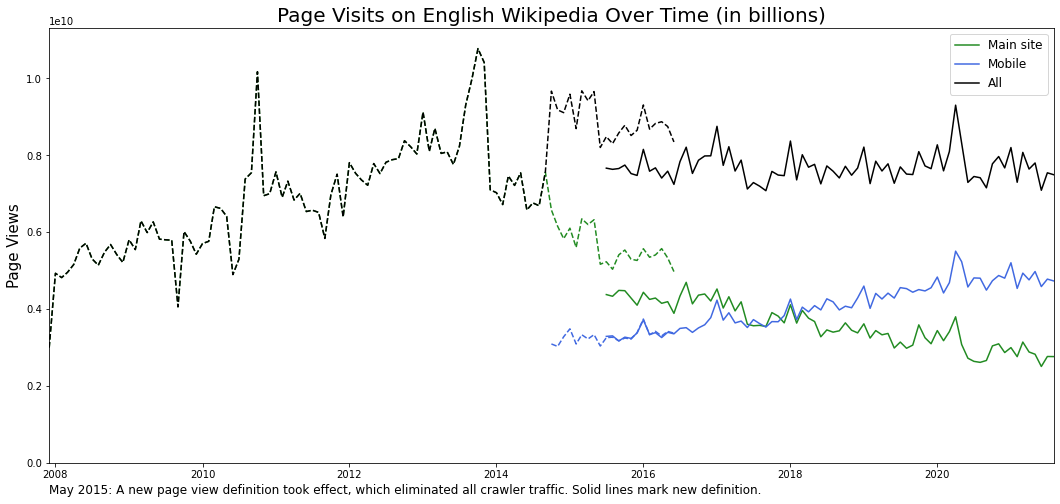

In [20]:
# Create a new date column that has just the year and month for timeseries plotting
df['date'] = pd.to_datetime(df['year'] * 100 + df['month'], format = '%Y%m')
# Convert 0s that were previously np.nan back to np.nan
df.replace(0, np.nan, inplace = True)

# Last date in the legacy Pagecounts series has a major drop off in views and is converted to np.nan for graphing purposes
max_date = max(df.loc[pd.notnull(df['pagecounts_all_views'])]['date'])
df.loc[df['date'] == max_date, ['pagecounts_all_views', 'pagecounts_desktop_views', 'pagecounts_mobile_views']] = np.nan

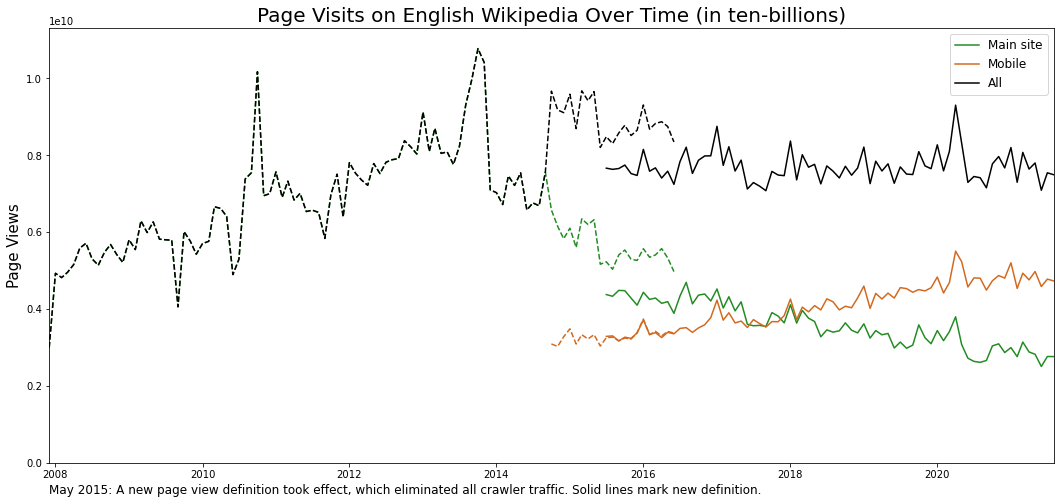

In [22]:
# Create the plot
plt.figure(figsize = (18, 8))
plt.plot(df['date'], df['pagecounts_desktop_views'], linestyle = '--', c = 'forestgreen')
plt.plot(df['date'], df['pageviews_desktop_views'], label = 'Main site', linestyle = '-', c = 'forestgreen')
plt.plot(df['date'], df['pagecounts_mobile_views'], linestyle = '--', c = 'chocolate')
plt.plot(df['date'], df['pageviews_mobile_views'], label = 'Mobile', linestyle = '-', c = 'chocolate')
plt.plot(df['date'], df['pagecounts_all_views'], linestyle = '--', c = 'black')
plt.plot(df['date'], df['pageviews_all_views'], label = 'All', linestyle = '-', c = 'black')
plt.xlim(min(df['date']), max(df['date']))
plt.ylim(0, (np.max(df['pagecounts_all_views']) * 1.05))
plt.xlabel('May 2015: A new page view definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.',
           fontsize = 12, loc = 'left')
plt.ylabel('Page Views', fontsize = 15)
plt.title('Page Visits on English Wikipedia Over Time (in ten-billions)', fontsize = 20)
plt.legend(fontsize = 12)

# Save the graph into the results folder assuming we are running from the src folder
plt.savefig('../results/wikipedia_page_vists_2008-2021')